Mount Drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


setting project workspace

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S10')

In [4]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/EVA4/S10/*

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/datasetloader.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/lr_finder.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/QuizDNN.ipynb'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/README.md'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/S10_Assignment.ipynb'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/train_test.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/utils.py'

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/gradcam':
gradcam.py  __init__.py  utils.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/models':
depthwise_separable_conv2d.py  __pycache__  QuizDNN.py	resnet.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/__pycache__':
datasetloader.cpython-36.pyc  train_test.cpython-36.pyc
lr_finder.cpython-36.pyc

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/transform':
albu_transforms.py  __init__.py  __pycache__  pytorch_transforms.py


Import Libraries

In [5]:
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 634kB 8.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=74f91088444117a80d47f45fcf1261325c2c4fd5d1209b507d48830583c4b1a5
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=e1360301ea54c6ce27f2c210adaf64249e6114517caa398bbc6a46c390e2b990
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm
import torch.backends.cudnn as cudnn

from transform.albu_transforms import *
import datasetloader as d
from models.resnet import *
from train_test import train, test


Loading data

In [0]:
# This is already available in albu_transforms.py. For quick experimentation, added here.
#from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, Rotate, GaussianBlur, VerticalFlip
#from albumentations.pytorch import ToTensor, ToTensorV2
#import numpy as np


# Albumentations Transformations
#transform_train_albu = Compose([
#    RandomCrop(height=32, width=32), #, always_apply=True 
#    HorizontalFlip(p=0.2),
#    VerticalFlip(p=0.0),
#    GaussianBlur(p=0.0),
#    Rotate(limit=20),
#    #ToTensor(),
#    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), always_apply=True),
#    Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=[0.4914, 0.4822, 0.4465], p=0.3),
#    ToTensorV2(always_apply=True)
#])


#transform_test_albu = Compose([
#    #ToTensor(),
#    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
#    ToTensorV2(always_apply=True)
#])

#transform_test_albu = AlbuCompose(transform_test_albu)
#transform_train_albu = AlbuCompose(transform_train_albu)

In [8]:
# setting up random seed and processing device
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    torch.cuda.manual_seed(SEED)
else:
    device = "cpu"
    torch.manual_seed(SEED)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

mean = (0.4914, 0.4822, 0.4465)

sd = (0.2023, 0.1994, 0.2010)

## getting training data loader
trainloader = d.get_dataloader_CIFAR10(True, cuda, transform=transform_train_albu)

## getting test data loader
testloader = d.get_dataloader_CIFAR10(False, cuda, transform=transform_test_albu)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


initializing network architecture

In [9]:
!pip install torchsummary
from torchsummary import summary
net = ResNet18()
net = net.to(device)
if cuda:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Model training and Evaluation

In [0]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #, weight_decay=5e-4

In [0]:
# LR Finder
try:
    from lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from lr_finder import LRFinder

In [32]:
# LR Finder
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode="exp") # start_lr=0.00001,


Learning rate search finished. See the graph with {finder_name}.plot()


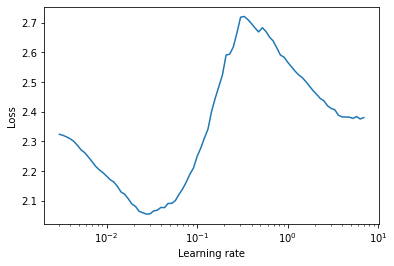

In [33]:
# Training Loss plot
lr_finder.plot()
plt.show()

Fastest decrease in loss is somewhere between 0.005 and 0.05. **0.001** is selected as the best learning rate.

In [34]:
# check the lowest value
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(lr[loss.index(min(loss))])

0.027542287033381664


In [0]:
# To restore the model and optimizer to their initial state use the reset() method.
lr_finder.reset()

**Validation Loss**

In [36]:
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=10, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


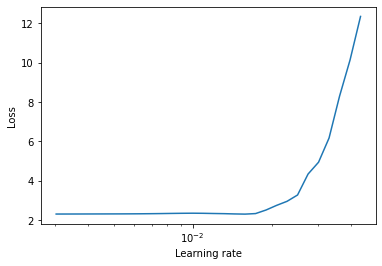

In [37]:
# Test Loss plot
lr_finder.plot(skip_end=0)

In [0]:
# To restore the model and optimizer to their initial state use the reset() method.
lr_finder.reset()

** Get Best LR using ReduceLROnPlateau**

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True) # mode='min'

In [0]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_acc = []
    train_loss = 0
    avg_train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        max_prob = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += max_prob.eq(target.view_as(max_prob)).sum().item()
        processed += len(data)
        accuracy = 100 * correct / processed
        pbar.set_description(desc= f'epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={accuracy:0.2f}')
        train_acc.append(accuracy)
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)

    #total = len(train_loader.dataset)
    #train_accuracy = 100. * correct / total
    print("SUCCESS {}".format(avg_train_loss))
    return avg_train_loss, accuracy

# model evaluation
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    avg_test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    avg_test_loss = test_loss / len(test_loader.dataset)

    total = len(test_loader.dataset)
    test_accuracy = 100. * correct / total
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        avg_test_loss, correct, len(test_loader.dataset), test_accuracy))
    return avg_test_loss, test_accuracy

In [50]:
# Model Training and Evaluation
train_losses  = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(0, 50):
    print("EPOCH {}".format(str(epoch)))
    train_loss, train_accuracy = train(net, device, trainloader, optimizer, epoch, criterion)
    test_loss, test_accuracy = test(net, device, testloader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    scheduler.step(test_loss)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 0


epoch=0 Loss=0.7506063580513 Batch_id=390 Accuracy=75.17: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s]

SUCCESS 0.005554469055533409



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7361/10000 (73.6%)

EPOCH 1


epoch=1 Loss=0.7650279998779297 Batch_id=390 Accuracy=77.92: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]

SUCCESS 0.004936538998484612



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7558/10000 (75.6%)

Epoch     2: reducing learning rate of group 0 to 1.0000e-04.
EPOCH 2


epoch=2 Loss=0.5183483362197876 Batch_id=390 Accuracy=82.87: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.003927228271961212



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8005/10000 (80.0%)

Epoch     3: reducing learning rate of group 0 to 1.0000e-05.
EPOCH 3


epoch=3 Loss=0.49494725465774536 Batch_id=390 Accuracy=83.91: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.003701940931081772



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8022/10000 (80.2%)

Epoch     4: reducing learning rate of group 0 to 1.0000e-06.
EPOCH 4


epoch=4 Loss=0.3590807318687439 Batch_id=390 Accuracy=84.23: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.00365401204764843



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8027/10000 (80.3%)

Epoch     5: reducing learning rate of group 0 to 1.0000e-07.
EPOCH 5


epoch=5 Loss=0.44502586126327515 Batch_id=390 Accuracy=84.07: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.0036598051434755326



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8020/10000 (80.2%)

Epoch     6: reducing learning rate of group 0 to 1.0000e-08.
EPOCH 6


epoch=6 Loss=0.5716220140457153 Batch_id=390 Accuracy=84.29: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.003659911866784096



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8022/10000 (80.2%)

EPOCH 7


epoch=7 Loss=0.6143163442611694 Batch_id=390 Accuracy=84.09: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.0036912496185302736



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8036/10000 (80.4%)

EPOCH 8


epoch=8 Loss=0.34978359937667847 Batch_id=390 Accuracy=84.20: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.0036591871058940886



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8037/10000 (80.4%)

EPOCH 9


epoch=9 Loss=0.5483394861221313 Batch_id=390 Accuracy=83.94: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.0036921576172113417



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8014/10000 (80.1%)

EPOCH 10


epoch=10 Loss=0.44792765378952026 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.0036813195502758025



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8027/10000 (80.3%)

EPOCH 11


epoch=11 Loss=0.3665873408317566 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.0036728393745422364



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8038/10000 (80.4%)

EPOCH 12


epoch=12 Loss=0.4349256157875061 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.0036821161687374117



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8026/10000 (80.3%)

EPOCH 13


epoch=13 Loss=0.4267357885837555 Batch_id=390 Accuracy=84.09: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.0036683316105604173



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8033/10000 (80.3%)

EPOCH 14


epoch=14 Loss=0.508621096611023 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.0036752276235818863



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8018/10000 (80.2%)

EPOCH 15


epoch=15 Loss=0.5091326832771301 Batch_id=390 Accuracy=84.08: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.0036952155315876007



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8016/10000 (80.2%)

EPOCH 16


epoch=16 Loss=0.428882896900177 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.003657569588422775



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8040/10000 (80.4%)

EPOCH 17


epoch=17 Loss=0.6913267970085144 Batch_id=390 Accuracy=84.21: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.00367757768034935



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8039/10000 (80.4%)

EPOCH 18


epoch=18 Loss=0.5062552690505981 Batch_id=390 Accuracy=84.07: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.003669691072702408



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8029/10000 (80.3%)

EPOCH 19


epoch=19 Loss=0.40774625539779663 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.0036724367368221283



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8030/10000 (80.3%)

EPOCH 20


epoch=20 Loss=0.5095773935317993 Batch_id=390 Accuracy=84.27: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.00366521744787693



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8015/10000 (80.2%)

EPOCH 21


epoch=21 Loss=0.6251537203788757 Batch_id=390 Accuracy=84.26: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.003654391098022461



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8021/10000 (80.2%)

EPOCH 22


epoch=22 Loss=0.41202229261398315 Batch_id=390 Accuracy=84.39: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.0036661526364088056



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8028/10000 (80.3%)

EPOCH 23


epoch=23 Loss=0.44214287400245667 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.0036855133402347567



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8026/10000 (80.3%)

EPOCH 24


epoch=24 Loss=0.41651827096939087 Batch_id=390 Accuracy=84.21: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.0036779039561748504



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8025/10000 (80.2%)

EPOCH 25


epoch=25 Loss=0.5757665038108826 Batch_id=390 Accuracy=83.98: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]

SUCCESS 0.00369350991666317



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8022/10000 (80.2%)

EPOCH 26


epoch=26 Loss=0.4236144423484802 Batch_id=390 Accuracy=84.42: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.0036524462270736695



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8026/10000 (80.3%)

EPOCH 27


epoch=27 Loss=0.26740574836730957 Batch_id=390 Accuracy=84.25: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]

SUCCESS 0.003668556363582611



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8031/10000 (80.3%)

EPOCH 28


epoch=28 Loss=0.4797359108924866 Batch_id=390 Accuracy=84.06: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]

SUCCESS 0.0036621526235342027



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8024/10000 (80.2%)

EPOCH 29


epoch=29 Loss=0.4588046967983246 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.0036894893026351927



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8019/10000 (80.2%)

EPOCH 30


epoch=30 Loss=0.41630834341049194 Batch_id=390 Accuracy=84.30: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.0036679339528083803



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8023/10000 (80.2%)

EPOCH 31


epoch=31 Loss=0.5658150911331177 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]

SUCCESS 0.0036828080809116364



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8019/10000 (80.2%)

EPOCH 32


epoch=32 Loss=0.610634982585907 Batch_id=390 Accuracy=83.96: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.0036876514494419096



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8039/10000 (80.4%)

EPOCH 33


epoch=33 Loss=0.44434723258018494 Batch_id=390 Accuracy=84.12: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.0036726231640577317



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8009/10000 (80.1%)

EPOCH 34


epoch=34 Loss=0.613427460193634 Batch_id=390 Accuracy=84.06: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.0036851559710502626



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8037/10000 (80.4%)

EPOCH 35


epoch=35 Loss=0.3193589150905609 Batch_id=390 Accuracy=84.10: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]

SUCCESS 0.0036847493600845336



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8029/10000 (80.3%)

EPOCH 36


epoch=36 Loss=0.38327157497406006 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]

SUCCESS 0.0036810300183296204



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8038/10000 (80.4%)

EPOCH 37


epoch=37 Loss=0.6599546670913696 Batch_id=390 Accuracy=83.95: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.0036714671659469605



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8039/10000 (80.4%)

EPOCH 38


epoch=38 Loss=0.3965783417224884 Batch_id=390 Accuracy=84.11: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]

SUCCESS 0.0036600360450148584



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8028/10000 (80.3%)

EPOCH 39


epoch=39 Loss=0.43091005086898804 Batch_id=390 Accuracy=84.39: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]

SUCCESS 0.0036343437099456786



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8028/10000 (80.3%)

EPOCH 40


epoch=40 Loss=0.4162687361240387 Batch_id=390 Accuracy=84.17: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]

SUCCESS 0.003664669869542122



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8033/10000 (80.3%)

EPOCH 41


epoch=41 Loss=0.42160695791244507 Batch_id=390 Accuracy=84.20: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]

SUCCESS 0.003661574642062187



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8026/10000 (80.3%)

EPOCH 42


epoch=42 Loss=0.4785359799861908 Batch_id=390 Accuracy=84.25: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.003667922379374504



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8026/10000 (80.3%)

EPOCH 43


epoch=43 Loss=0.42432326078414917 Batch_id=390 Accuracy=84.13: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]

SUCCESS 0.0036654976558685303



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8027/10000 (80.3%)

EPOCH 44


epoch=44 Loss=0.4791012704372406 Batch_id=390 Accuracy=84.14: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]

SUCCESS 0.003679058505296707



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8019/10000 (80.2%)

EPOCH 45


epoch=45 Loss=0.4050799310207367 Batch_id=390 Accuracy=84.20: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]

SUCCESS 0.003658054878115654



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8035/10000 (80.3%)

EPOCH 46


epoch=46 Loss=0.4989766478538513 Batch_id=390 Accuracy=84.14: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]

SUCCESS 0.0036794787907600403



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8031/10000 (80.3%)

EPOCH 47


epoch=47 Loss=0.5637913942337036 Batch_id=390 Accuracy=84.15: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]

SUCCESS 0.0036883453768491747



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8023/10000 (80.2%)

EPOCH 48


epoch=48 Loss=0.44600963592529297 Batch_id=390 Accuracy=84.29: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]

SUCCESS 0.0036612364321947097



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8013/10000 (80.1%)

EPOCH 49


epoch=49 Loss=0.5686420798301697 Batch_id=390 Accuracy=84.03: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]

SUCCESS 0.003698762929439545



Test set: Average loss: 0.0044, Accuracy: 8008/10000 (80.1%)



In [0]:

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table


def plot_lines(*args, **kwargs):
    """
    Plots accuracy as a line
    """
    lbls = kwargs.get('labels')
    title = kwargs.get('title')
    save = kwargs.get('save')
    plot_df = pd.DataFrame(columns=lbls)
    # get the max length
    max_len = 0
    for i, data in enumerate(args):
        arr_len = len(data)
        if arr_len > max_len:
            max_len = arr_len

    for i, data in enumerate(args):
        # check the array length and fill the gap with max_len with None
        # This will not happen normally though
        arr_len = len(data)
        if arr_len < max_len:
            data = data + [None] * (max_len - arr_len)
        data_arr = np.array(data)
        # data_arr = data_arr[~np.isnan(data_arr)]
        plot_df.loc[:, lbls[i]] = data_arr

    # sns.distplot(plot_df, hist=False)
    ax = plot_df.plot.line()
    ax.set_title(title)
    if save:
        plt_name = title + ".png"  # + str(time.time()) + ".png"
        plt.savefig(plt_name)
    else:
        plt.show()

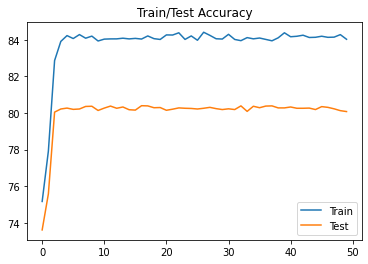

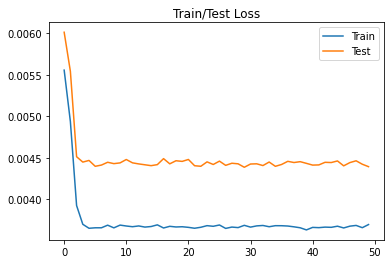

In [52]:
plot_labels = ['Train', 'Test']
plot_lines(train_accuracies, test_accuracies, labels=plot_labels, title="Train/Test Accuracy", save=False)
plot_lines(train_losses, test_losses, labels=plot_labels, title="Train/Test Loss", save=False)

### Get some misclassified images and do the GridCam on them

Find the misclassified images

In [0]:
#torch.save(net, 'resnet_s10.pth')
model = net
# Load the model 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model=torch.load('resnet_s10.pth')
#model.eval()
#model = torch.nn.DataParallel(model, device_ids=[0])
net = torch.nn.DataParallel(net, device_ids=[0])

In [41]:
# May be, there's an easy way to get the misclassified images that I am not aware of. Ayway, repreidtcing a set of images and getting the misclassifed
# images
mc_images, mc_labels, mc_pred_labels = get_missclassfied_images(model, device, testloader, classes)

KeyboardInterrupt: ignored

ValueError: ignored

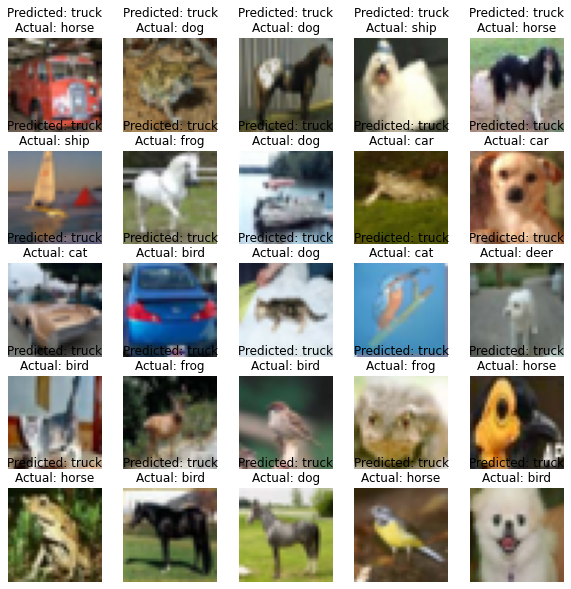

In [58]:
plot_misclassified_images(mc_images, classes, mean=mean, sd=sd, pred_labels=mc_pred_labels, labels=mc_labels)

In [53]:
#print(type(mc_images[0].cpu().numpy()))
print((mc_images[0][0].shape))

torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat  bird truck   car


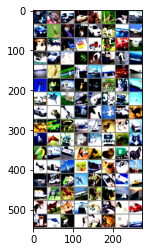

In [0]:
from utils import *
# Let's visualize some of the images
# get some random training images
dataiter = iter(trainloader)
images_orig, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images_orig))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Show the actual image and GridCAM**

In [62]:
# get one image to test
num_of_images = len(mc_images)

for index in range(1, num_of_images + 1):
    #ax = plt.subplot(5, 5, index+1)
    img = mc_images[index - 1].cpu()
    if img.dim() == 2:  # single image H x W
        img = img.unsqueeze(0)
    if img.dim() == 3:  # single image
        if img.size(0) == 1:  # if single-channel, convert to 3-channel
            img = torch.cat((img, img, img), 0)
        img = img.unsqueeze(0)

    if img.dim() == 4 and img.size(1) == 1:  # single-channel images
        img = torch.cat((img, img, img), 1)
    plot_cam(image_test, mean=mean, sd=sd, device=device)

AttributeError: ignored